In [179]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import spacy
import re
import nltk
from nltk.corpus import stopwords
from collections import Counter
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

In [180]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

# Competiton data loading

In [181]:
import zipfile
#Extracting zipped dataset to working directory


with zipfile.ZipFile("/kaggle/input/sentiment-analysis-on-movie-reviews/test.tsv.zip","r") as z:
    z.extractall("/kaggle/working/")

In [182]:
with zipfile.ZipFile("/kaggle/input/sentiment-analysis-on-movie-reviews/train.tsv.zip","r") as z:
    z.extractall("/kaggle/working/")

In [183]:
data_df = pd.read_csv('/kaggle/working/train.tsv', sep='\t')

data_df.head(10)

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2
5,6,1,of escapades demonstrating the adage that what...,2
6,7,1,of,2
7,8,1,escapades demonstrating the adage that what is...,2
8,9,1,escapades,2
9,10,1,demonstrating the adage that what is good for ...,2


In [184]:
test_df = pd.read_csv('/kaggle/working/test.tsv', sep='\t')

test_df.head(10)

,PhraseId,SentenceId,Phrase
0,156061,8545,An intermittently pleasing but mostly routine ...
1,156062,8545,An intermittently pleasing but mostly routine ...
2,156063,8545,An
3,156064,8545,intermittently pleasing but mostly routine effort
4,156065,8545,intermittently pleasing but mostly routine
5,156066,8545,intermittently pleasing but
6,156067,8545,intermittently pleasing
7,156068,8545,intermittently
8,156069,8545,pleasing
9,156070,8545,but


# Data Exploration

In [185]:
data_df[data_df['SentenceId'] == 4]

,PhraseId,SentenceId,Phrase,Sentiment
116,117,4,A positively thrilling combination of ethnogra...,3
117,118,4,A positively thrilling combination of ethnogra...,4
118,119,4,A positively thrilling combination of ethnogra...,4
119,120,4,A positively thrilling combination,3
120,121,4,positively thrilling combination,3
121,122,4,positively,3
122,123,4,thrilling combination,3
123,124,4,thrilling,4
124,125,4,combination,2
125,126,4,"of ethnography and all the intrigue , betrayal...",2


Try training first, but an Idea could be to remove all phrases except the first one, and let the model understand the negativity or positivity of the different parts

In [186]:
length_dataset = len(data_df)
num_sentences = data_df.SentenceId.nunique()

print(f"Dataset length : {length_dataset}\n")
print(f"Number of sentences : {num_sentences}\n")

Dataset length : 156060

Number of sentences : 8529



Text(0, 0.5, 'Frequency')

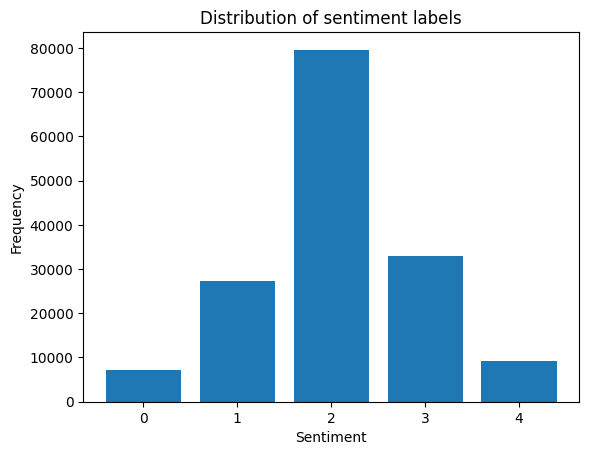

In [187]:
label_frequencies = dict(data_df.Sentiment.value_counts())
plt.figure()
plt.bar(label_frequencies.keys(),label_frequencies.values())
plt.title("Distribution of sentiment labels")
plt.xlabel("Sentiment")
plt.ylabel("Frequency")

Concentration in Neutral sentiment

# Data Preprocessing

In [188]:
train_df,valid_df = train_test_split(data_df,test_size=0.3,random_state= 42)

In [189]:
print(train_df.shape)
print(valid_df.shape)

(109242, 4)
(46818, 4)


## Tokenization

In [190]:
def preprocess_string(s):
    # Remove all non-word characters (everything except numbers and letters)
    s = re.sub(r"[^\w\s]", '', s)
    # Replace all runs of whitespaces with no space
    s = re.sub(r"\s+", '', s)
    # replace digits with no space
    s = re.sub(r"\d", '', s)
    
    #Transforms in lower case
    s = s.lower()
    return s

In [191]:
# Load spacy tokenizer
nlp = spacy.load('en_core_web_sm')

def tokenize_simple(text):
    return [preprocess_string(token.text) for token in nlp(text)]

def tokenize(text, use_stopwords= False):
    
    if use_stopwords == True:
        stop_words = set(stopwords.words('english'))
    else:
        stop_words = set()
    
    word_list = []
    for word in text.lower().split():
        word = preprocess_string(word)
        if word not in stop_words and word != '':
            word_list.append(word)
            
    #To deal with issues of removing stop words and endim with empty lists, use <unk> as a placeholder        
    if not word_list:
        word_list.append('<unk>')
                
    return word_list

Uses english language small model, which defines a preprocessing pipeline, including tokenization.

Uses stop words to remove common words in english that are not necessary to gauge the sentiment --> For other kinds of tasks this words might be important, so alway think before performing this step

In [192]:
print(tokenize(train_df.iloc[1].loc['Phrase']))

['just', 'a', 'bunch', 'of', 'good', 'actors', 'flailing', 'around', 'in', 'a', 'caper', 'that', 's', 'neither', 'original', 'nor', 'terribly', 'funny']


In [193]:
print(tokenize_simple(train_df.iloc[1].loc['Phrase']))

['just', 'a', 'bunch', 'of', 'good', 'actors', 'flailing', 'around', 'in', 'a', 'caper', 'that', 's', 'neither', 'original', 'nor', 'terribly', 'funny']


In [194]:
print(stopwords.words('english'))


['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

## Vocabulary building

In [195]:
def build_vocab(df, tokenizer, max_size= 2000, min_freq=3):
    counter = Counter()
    for text in df['Phrase']:
        tokens = tokenizer(text)
        counter.update(tokens)
    
    # Limit vocabulary size and filter low frequency words
    
    # Filter out words with frequency less than min_freq
    filtered_vocab = {word: freq for word, freq in counter.items() if freq >= min_freq}
    
    # Sort words by frequency (highest to lowest)
    sorted_vocab = sorted(filtered_vocab.items(), key=lambda item: item[1], reverse=True)
    
    # Limit to max_size most frequent words
    limited_vocab = sorted_vocab[:max_size]
    
    #Very bad solution --> Search for a better one
    vocab_dict_intermediate = {word: idx for idx, (word, freq) in enumerate(limited_vocab)}
    
    if vocab_dict_intermediate.get('<unk>') is not None:
        # Create vocabulary dictionary
        vocab_dict = {word: idx + 1 for idx, (word, freq) in enumerate(limited_vocab)}
    else:
        vocab_dict = {word: idx + 2 for idx, (word, freq) in enumerate(limited_vocab)}
        vocab_dict['<unk>'] = 0
        
    vocab_dict['<pad>'] = 1
    return vocab_dict

In [196]:
vocab = build_vocab(train_df, tokenize)

In [197]:
print(vocab)

{'the': 1, 'a': 2, 'of': 3, 'and': 4, 'to': 5, 's': 6, 'in': 7, 'is': 8, 'that': 9, 'it': 10, 'as': 11, 'with': 12, 'for': 13, 'its': 14, 'film': 15, 'an': 16, 'movie': 17, 'this': 18, 'be': 19, 'but': 20, 'you': 21, 'on': 22, 'by': 23, 'nt': 24, 'more': 25, 'his': 26, 'one': 27, 'about': 28, 'at': 29, 'not': 30, 'or': 31, 'than': 32, 'from': 33, 'have': 34, 'all': 35, 'are': 36, 'like': 37, 'has': 38, 'so': 39, 'story': 40, 'rrb': 41, 'out': 42, 'who': 43, 'most': 44, 'into': 45, 'too': 46, 'lrb': 47, 'up': 48, 'good': 49, 'if': 50, 'their': 51, 'what': 52, 'characters': 53, 'much': 54, 'i': 55, 'can': 56, 'no': 57, 'just': 58, 'your': 59, 'some': 60, 'time': 61, 'comedy': 62, 'does': 63, 'even': 64, 'little': 65, 'will': 66, 'way': 67, 'funny': 68, 'life': 69, 'any': 70, 'very': 71, 'been': 72, 'only': 73, 'make': 74, 'which': 75, 'movies': 76, 'he': 77, 'love': 78, 'was': 79, 'there': 80, 'do': 81, 'enough': 82, 'work': 83, 'new': 84, 'her': 85, 'own': 86, 'bad': 87, 'us': 88, 'some

## Encoding

In [198]:
def encode_text(text, vocab, tokenizer):
    return [vocab.get(token, vocab['<unk>']) for token in tokenizer(text)]

In [199]:
def encode_label(label):
    return int(label) # Rescals labels to be from 0 to 4 instead of 1 to 5 --> Problems with loss function

In [200]:
def build_reverse_vocab(vocab):
    reverse_vocab = {idx: word for word, idx in vocab.items()}
    return reverse_vocab

def decode_text(encoded_sequence, reverse_vocab):
    return [reverse_vocab[idx] if idx in reverse_vocab else '<unk>' for idx in encoded_sequence]

reverse_vocab = build_reverse_vocab(vocab)

In [201]:
encoded_test = encode_text(train_df.iloc[0].loc['Phrase'],vocab,tokenize)
decoded_text = decode_text(encoded_test,reverse_vocab)
print(encoded_test)
print(decoded_text)

[149, 30, 13, 124, 606, 18, 154, 71, 68, 749, 865, 62, 342, 2, 134, 67, 1150, 749, 1, 749, 3, 1, 1191, 749, 15, 956, 46, 134, 749, 5, 749, 749]
['while', 'not', 'for', 'every', 'taste', 'this', 'often', 'very', 'funny', '<unk>', 'grossout', 'comedy', 'goes', 'a', 'long', 'way', 'toward', '<unk>', '<pad>', '<unk>', 'of', '<pad>', 'national', '<unk>', 'film', 'franchise', 'too', 'long', '<unk>', 'to', '<unk>', '<unk>']


# Dataset Creation

In [202]:
def evaluate_sequence_lengths(df,tokenizer):
    
    lengths = df['Phrase'].apply(lambda x : len(tokenizer(x)))
    lengths_freq = lengths.value_counts()
    
    return lengths_freq

In [203]:
lengths_freq = evaluate_sequence_lengths(train_df,tokenize)


Text(0, 0.5, 'Frequency')

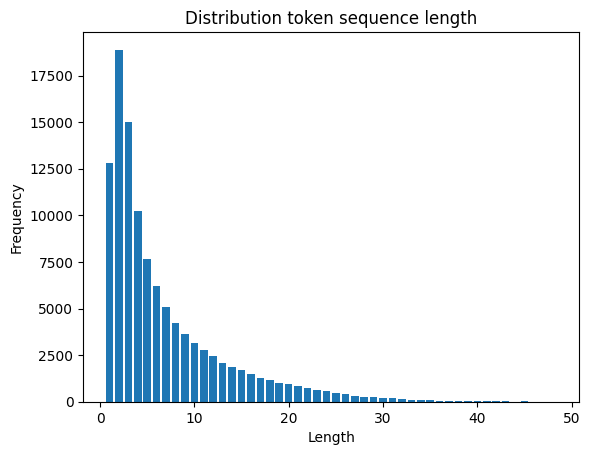

In [204]:
plt.figure()
plt.bar(lengths_freq.keys(),lengths_freq.values)
plt.title("Distribution token sequence length")
plt.xlabel("Length")
plt.ylabel("Frequency")

Make max sequence length 15 tokens

In [205]:
class ReviewsDataset(Dataset):
    def __init__(self, df, vocab, tokenizer, max_length=15):
        self.texts = [encode_text(text, vocab, tokenizer) for text in df['Phrase']]
        self.labels = [encode_label(label) for label in df['Sentiment']]
        self.max_length = max_length
        self.vocab = vocab
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        if len(text) < self.max_length:
            text += [self.vocab['<pad>']] * (self.max_length - len(text))
        else:
            text = text[:self.max_length]
        return torch.tensor(text, dtype=torch.long), torch.tensor(label, dtype=torch.long)

In [206]:
MAX_LENGTH = 15
train_dataset = ReviewsDataset(train_df,vocab,tokenize,MAX_LENGTH)
valid_dataset = ReviewsDataset(valid_df,vocab,tokenize,MAX_LENGTH)

In [207]:
len(train_dataset)

109242

In [208]:
X,y = train_dataset[5]
print(X)
print(y)

tensor([ 18, 377,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
          1])
tensor(2)


In [209]:
X,y = valid_dataset[5]
print(len(valid_dataset))
print(X)
print(y)

46818
tensor([ 58,  46, 310,   4, 749,   5, 749,  14, 769, 118,   1,   1,   1,   1,
          1])
tensor(1)


In [210]:
BATCH_SIZE = 128

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=BATCH_SIZE)

In [211]:
b, (X,y) = next(enumerate(valid_dataloader))
print(X)
print(y)

tensor([[   6,   11,  749,  ...,    1,    1,    1],
        [ 215,   62,    4,  ...,   42,    5,   19],
        [   3,  167,  504,  ...,    1,    1,    1],
        ...,
        [ 197,    7, 1247,  ...,    1,    1,    1],
        [ 749,    1,    1,  ...,    1,    1,    1],
        [   3,  675,    1,  ...,    1,    1,    1]])
tensor([2, 4, 2, 2, 1, 1, 1, 3, 4, 1, 0, 2, 0, 3, 1, 4, 2, 1, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 1, 1, 2, 0, 2, 2, 3, 2, 2, 3, 2, 4, 4, 2, 2, 1, 3, 3, 3, 2,
        2, 1, 2, 3, 1, 2, 4, 1, 2, 3, 3, 2, 3, 2, 3, 2, 1, 2, 2, 1, 1, 2, 3, 2,
        1, 2, 2, 3, 3, 2, 2, 2, 2, 1, 1, 3, 2, 2, 2, 1, 2, 4, 2, 3, 2, 2, 2, 2,
        2, 3, 3, 1, 1, 4, 0, 2, 2, 2, 2, 2, 2, 2, 2, 4, 2, 1, 1, 2, 3, 2, 3, 3,
        4, 2, 2, 3, 2, 2, 2, 2])


# Model Construction

In [212]:
class LSTM(nn.Module):
    
    
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, 
                 bidirectional, dropout, pad_idx, pretrained_embeddings):
        
        super().__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_idx)
        self.embedding.weight.data.copy_(pretrained_embeddings)
        self.embedding.weight.requires_grad = False  # Freeze embedding layer
        
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=n_layers, 
                            bidirectional=bidirectional, dropout=dropout)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        self.dropout = nn.Dropout(dropout)
        
        
    def forward(self, text):
        
        embedded = self.dropout(self.embedding(text))
        output, (hidden, cell) = self.lstm(embedded)
        hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1))
        
        return self.fc(hidden)

In [213]:
class SentimentRNN(nn.Module):
    
    
    def __init__(self,no_layers,vocab_size,output_dim,hidden_dim,embedding_dim,pad_idx, pretrained_embeddings, drop_prob=0.3):
        super(SentimentRNN,self).__init__()
 
        self.output_dim = output_dim
        self.hidden_dim = hidden_dim
 
        self.no_layers = no_layers
        self.vocab_size = vocab_size
    
        # embedding and LSTM layers
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_idx)
        self.embedding.weight.data.copy_(pretrained_embeddings)
        self.embedding.weight.requires_grad = False  # Freeze embedding layer
        
        #lstm
        self.lstm = nn.LSTM(input_size=embedding_dim,hidden_size=self.hidden_dim,
                           num_layers=no_layers, batch_first=True)
        
        
        # dropout layer
        self.dropout = nn.Dropout(drop_prob)
    
        # linear and sigmoid layer
        self.fc = nn.Linear(self.hidden_dim, output_dim)
        
    def forward(self,x,hidden):
        
        batch_size = x.size(0)
        # embeddings and lstm_out
        embeds = self.embedding(x)  # shape: B x S x Feature   since batch = True
        #print(embeds.shape)  #[50, 500, 1000]
        lstm_out, hidden = self.lstm(embeds, hidden)
        
        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim) 
        
        # dropout and fully connected layer
        out = self.dropout(lstm_out)
        out = self.fc(out)
        
        # sigmoid function
        softmax_out = out
        
        
        softmax_out = softmax_out.view(batch_size, -1, self.output_dim)
        
        # Get the last output for each sequence in the batch
        # This ensures we take the prediction from the last time step of each sequence
        softmax_out = softmax_out[:, -1, :]
        
        # reshape to be batch_size first
        #sig_out = sig_out.view(batch_size, -1)

        #sig_out = sig_out[:, -1] # get last batch of labels
        
        # return last sigmoid output and hidden state
        return softmax_out, hidden
    
    def init_hidden(self, batch_size):
        ''' Initializes hidden state '''
        # Create two new tensors with sizes n_layers x batch_size x hidden_dim,
        # initialized to zero, for hidden state and cell state of LSTM
        h0 = torch.zeros((self.no_layers,batch_size,self.hidden_dim))
        c0 = torch.zeros((self.no_layers,batch_size,self.hidden_dim))
        hidden = (h0,c0)
        return hidden

In [214]:
class SentimentAnalRNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, bidirectional, dropout,pretrained_embeddings):
        super(SentimentAnalRNN, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.embedding.weight.data.copy_(pretrained_embeddings)
        self.embedding.weight.requires_grad = False  # Freeze embedding layer
        self.lstm = nn.LSTM(embedding_dim,
                            hidden_dim,
                            num_layers=n_layers,
                            bidirectional=bidirectional,
                            dropout=dropout,
                            batch_first=True)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim * 2 if bidirectional else hidden_dim, output_dim)

    def forward(self, x):
        embedded = self.embedding(x)
        lstm_out, (hidden, cell) = self.lstm(embedded)
        if self.lstm.bidirectional:
            hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1))
        else:
            hidden = self.dropout(hidden[-1,:,:])
        return self.fc(hidden)

In [215]:
import os

# URL of the file to download
url = "http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip"
file_name = "glove.6B.zip"

# Check if the file exists
if not os.path.isfile(file_name):
    # Download the file using wget
    !wget {url}

In [216]:
#with zipfile.ZipFile("/kaggle/working/glove.6B.zip","r") as z:
#    z.extractall("/kaggle/working/")

In [217]:
# Model parameters
INPUT_DIM = len(vocab)
EMBEDDING_DIM = 100
HIDDEN_DIM = 256
OUTPUT_DIM = 5 #Multiclass classification problem
N_LAYERS = 2
BIDIRECTIONAL = True
DROPOUT = 0.5
PAD_IDX = vocab['<pad>']

# Load pre-trained embeddings
def load_pretrained_embeddings(filepath, vocab, emb_dim):
    embeddings = np.zeros((len(vocab), emb_dim))
    with open(filepath, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], dtype='float32')
            if word in vocab:
                embeddings[vocab[word]] = vector
    return torch.tensor(embeddings)

pretrained_embeddings = load_pretrained_embeddings('glove.6B.100d.txt', vocab, EMBEDDING_DIM)

# Instantiate the model
#model = LSTM(INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM, N_LAYERS, 
#             BIDIRECTIONAL, DROPOUT, PAD_IDX, pretrained_embeddings).to(device)
#model_2 = SentimentRNN(N_LAYERS,INPUT_DIM,OUTPUT_DIM,HIDDEN_DIM,EMBEDDING_DIM,PAD_IDX,pretrained_embeddings).to(device)
model_3 = SentimentAnalRNN(INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM, N_LAYERS, BIDIRECTIONAL, DROPOUT,pretrained_embeddings).to(device)

In [218]:
#Checks to see if everything is working correctly
b, (X,y) = next(enumerate(train_dataloader))
model_3.eval()
X, y = X.to(device), y.to(device)
with torch.inference_mode():
    preds = model_3(X)


In [219]:
print(X.shape)
print(y.shape)

torch.Size([128, 15])
torch.Size([128])


In [220]:
preds.shape

torch.Size([128, 5])

In [221]:
print(torch.softmax(preds,dim=1))
print(torch.argmax(torch.softmax(preds,dim=1),dim=1))

tensor([[0.2000, 0.1957, 0.2030, 0.2049, 0.1963],
        [0.1986, 0.1976, 0.2039, 0.2037, 0.1962],
        [0.2000, 0.1957, 0.2030, 0.2049, 0.1963],
        [0.1961, 0.1961, 0.2043, 0.2054, 0.1981],
        [0.2000, 0.1957, 0.2030, 0.2049, 0.1963],
        [0.1982, 0.1965, 0.2030, 0.2050, 0.1973],
        [0.2011, 0.1972, 0.2052, 0.2010, 0.1956],
        [0.1985, 0.1961, 0.2024, 0.2053, 0.1977],
        [0.1985, 0.1942, 0.2032, 0.2056, 0.1985],
        [0.1990, 0.1960, 0.2037, 0.2051, 0.1962],
        [0.2001, 0.1948, 0.2032, 0.2051, 0.1968],
        [0.1993, 0.1946, 0.2033, 0.2043, 0.1984],
        [0.1985, 0.1957, 0.2033, 0.2053, 0.1972],
        [0.1999, 0.1966, 0.2031, 0.2040, 0.1963],
        [0.2004, 0.1968, 0.2034, 0.2044, 0.1950],
        [0.2001, 0.1979, 0.2039, 0.2028, 0.1954],
        [0.1970, 0.1958, 0.2052, 0.2047, 0.1973],
        [0.2011, 0.1964, 0.2012, 0.2047, 0.1966],
        [0.2000, 0.1957, 0.2030, 0.2049, 0.1963],
        [0.1998, 0.1963, 0.2044, 0.2048, 0.1948],


# Training

TO DO: Training. Use Softmax and Multiclass Cross entropy 

# TO DO : Solve problem created by using unk as placeholder for empty list --> it appears in the dictionary before being set again 

In [222]:
LEARNING_RATE = 1e-4

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_3.parameters(), lr=LEARNING_RATE)


In [223]:
def accuracy_fn(preds, y):
    rounded_preds = torch.argmax(torch.softmax(preds,dim=1),dim=1)
    correct = (rounded_preds == y).float()
    return correct.sum() / len(correct)

In [224]:
from tqdm.auto import tqdm
from typing import Dict, List, Tuple

def train_step(model: torch.nn.Module, 
               dataloader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               optimizer: torch.optim.Optimizer,
               device: torch.device,
              accuracy_fn) -> Tuple[float, float]:
    
    model.train()


    train_loss = 0
    
    train_accuracy = 0
    
    for batch, (X, y) in enumerate(dataloader):
        # Send data to target device
        X = X.to(device, dtype=torch.long)
        y = y.to(device, dtype=torch.long)
        

        # 1. Forward pass
        #with torch.cuda.amp.autocast():
        y_pred = model(X)
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()
            
        
        accuracy = accuracy_fn(y_pred,y)
        train_accuracy += accuracy           

                
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        

    # Adjust metrics to get average loss and accuracy per batch 
    train_loss = train_loss / len(dataloader)
    train_accuracy = train_accuracy / len(dataloader)
    
    return train_loss, train_accuracy

In [225]:
def test_step(model: torch.nn.Module, 
              dataloader: torch.utils.data.DataLoader, 
              loss_fn: torch.nn.Module,
              device: torch.device,
             accuracy_fn) -> Tuple[float, float]:
    
    # Put model in eval mode
    model.eval() 



    # Setup test loss and test accuracy values
    test_loss = 0
    test_accuracy = 0
    

    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X = X.to(device, dtype=torch.long)
            y = y.to(device, dtype=torch.long)
            

            # 1. Forward pass
            test_pred_logits = model(X)
            
            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()
            
            accuracy = accuracy_fn(test_pred_logits, y)
            test_accuracy += accuracy


            


    # Adjust metrics to get average loss and accuracy per batch 
    test_loss = test_loss / len(dataloader)
    test_accuracy = test_accuracy / len(dataloader)
    
    
    return test_loss, test_accuracy

In [226]:
def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device,
          accuracy_fn,
         save_freq = 0,
         save_name = 'Sample') -> Dict[str, List]:

    # Create empty results dictionary
    results = {"train_loss": [],
        "train_accuracy" : [],
        "test_loss": [],
        "test_accuracy" : []
    }

  # Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss,train_accuracy = train_step(model=model,
                              dataloader=train_dataloader,
                              loss_fn=loss_fn,
                              optimizer=optimizer,
                              device=device,
                               accuracy_fn=accuracy_fn)
        test_loss,test_accuracy = test_step(model=model,
                              dataloader=test_dataloader,
                              loss_fn=loss_fn,
                              device=device,
                              accuracy_fn=accuracy_fn)

        # Print out what's happening
        print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.10f} | train_accuracy: {train_accuracy:.4f} |" 
          f"test_loss: {test_loss:.10f} |  test_accuracy: {test_accuracy:.4f}"      
        )

        # Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_accuracy"].append(train_accuracy)
        
        results["test_loss"].append(test_loss)
        results["test_accuracy"].append(test_accuracy)
        
        if (save_freq > 0) & (epoch % save_freq == 0):
            print(f"Epoch: {epoch + 1} | Saving model")
            torch.save(obj=model.state_dict(),f=("/kaggle/working/models/" + save_name +".pth"))
            
        
    # Return the filled results at the end of the epochs
    return results

In [227]:
os.makedirs("/kaggle/working/models", exist_ok=True)

In [228]:
from timeit import default_timer as timer 
start_time = timer()

EPOCHS = 30
# Setup training and save the results

results = train(model=model_3,
            train_dataloader=train_dataloader,
            test_dataloader=valid_dataloader,
            optimizer=optimizer,
            loss_fn=loss_fn,
            epochs=EPOCHS,
            device=device,
            accuracy_fn=accuracy_fn,
            save_freq=5,
            save_name = "LSTM_vocab2xsize_NOstopwords")

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1536736336 | train_accuracy: 0.5409 |test_loss: 1.0776147250 |  test_accuracy: 0.5686
Epoch: 1 | Saving model
Epoch: 2 | train_loss: 1.0663511613 | train_accuracy: 0.5728 |test_loss: 1.0516732588 |  test_accuracy: 0.5769
Epoch: 3 | train_loss: 1.0494177519 | train_accuracy: 0.5802 |test_loss: 1.0412662075 |  test_accuracy: 0.5814
Epoch: 4 | train_loss: 1.0379599969 | train_accuracy: 0.5838 |test_loss: 1.0405726936 |  test_accuracy: 0.5823
Epoch: 5 | train_loss: 1.0287014650 | train_accuracy: 0.5885 |test_loss: 1.0228044734 |  test_accuracy: 0.5875
Epoch: 6 | train_loss: 1.0209446357 | train_accuracy: 0.5924 |test_loss: 1.0166582594 |  test_accuracy: 0.5916
Epoch: 6 | Saving model
Epoch: 7 | train_loss: 1.0130565649 | train_accuracy: 0.5948 |test_loss: 1.0156079397 |  test_accuracy: 0.5910
Epoch: 8 | train_loss: 1.0061102621 | train_accuracy: 0.5974 |test_loss: 1.0042890605 |  test_accuracy: 0.5966
Epoch: 9 | train_loss: 0.9992147916 | train_accuracy: 0.6008 |te

# Predictions

In [121]:

def predict_sentiment(text, vocab, tokenizer,  model, device, max_length = 15):
    text = encode_text(text, vocab, tokenizer)
    if len(text) < max_length:
            text += [vocab['<pad>']] * (max_length - len(text))
    else:
        text = text[:max_length]
    X = torch.tensor(text, dtype=torch.long).to(device)
    model.eval()
    with torch.inference_mode():
        preds = model(X.unsqueeze(0))
    
    pred_label = torch.argmax(torch.softmax(preds,dim=1),dim=1)
    
    return pred_label

In [124]:
text_1 = "This movie is absolutely horrible! Never watching it again."
text_2 = "Simply beautiful! Good acting and amazing imagery! Recommend it 100%."
preds_test = predict_sentiment(text_1, vocab, tokenize, model_3, device, 15)

In [125]:
sentiment_dict = {0: "Negative", 1: "Somewhat Negative", 2: "Neutral", 3: "Somewhat Positive", 4: "Positive"}
print(sentiment_dict[preds_test[0].item()])


Negative
